# Random Forest

In [13]:
# import modules 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import uniform

# Data Preprocessing

In [14]:
# Load the cleaned data with DEP_DELAY included
df = pd.read_csv("../flight-delay-dataset.csv")

# Remove NAs
df.isna().sum()
df.dropna(inplace=True)

# No duplicates
df.duplicated().value_counts()

False    28818
Name: count, dtype: int64

In [15]:
# Remove TAIL_NUM and TAXI_OUT
df.drop(columns=['TAIL_NUM', 'TAXI_OUT', 'DEP_TIME_M'], inplace=True)

# Convert DEW_POINT to int
df['Dew Point'] = df['Dew Point'].astype(int)

# Encode categorical variables
columns_to_encode = ['OP_UNIQUE_CARRIER', 'DEST', 'Wind', 'Condition']
df_encoded = pd.get_dummies(df, columns=columns_to_encode)

# Remove all values beyond 3 standard deviations from the mean
mean_dep_delay = df_encoded['DEP_DELAY'].mean()
std_dep_delay = df_encoded['DEP_DELAY'].std()
upper_threshold = mean_dep_delay + (3 * std_dep_delay)
df_encoded = df_encoded[df_encoded['DEP_DELAY'] <= upper_threshold]

# Remove all values below 0
df_encoded = df_encoded[df_encoded['DEP_DELAY'] >= 15]

# Train/Test Split

In [16]:
# Split 80/20 train-test
X = df_encoded.drop(columns=['DEP_DELAY'])
y = df_encoded['DEP_DELAY']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Develop and Fit Model

In [17]:
# Find MSE if you were to predict all with the average DEP_DELAY in the training set
y_mean = y_train.mean()
y_train_pred_mean = np.full(y_train.shape, y_mean)
y_test_pred_mean = np.full(y_test.shape, y_mean)
mse_train_mean = mean_squared_error(y_train, y_train_pred_mean)
mse_test_mean = mean_squared_error(y_test, y_test_pred_mean)
mae_train_mean = mean_absolute_error(y_train, y_train_pred_mean)
mae_test_mean = mean_absolute_error(y_test, y_test_pred_mean)
print(f'Dummy Regressor MSE: {mse_test_mean}')
print(f'Dummy Regressor MAE: {mae_test_mean}')

Dummy Regressor MSE: 726.0180249932113
Dummy Regressor MAE: 22.20996029186083


In [18]:
# Initialize Basic Random Forest Regressor
rand_forest = RandomForestRegressor(random_state=42, n_estimators=100) 

# Train the model
rand_forest.fit(X_train, y_train)

# Make predictions
y_pred = rand_forest.predict(X_test)

# Calculate MSE
mse = mean_squared_error(y_test, y_pred)
print("Base Random Forest MSE:", mse)

# Calculate MAE
mae = mean_absolute_error(y_test, y_pred)
print("Base Random Forest MAE:", mae)

Base Random Forest MSE: 447.80832588401694
Base Random Forest MAE: 17.0391513437058


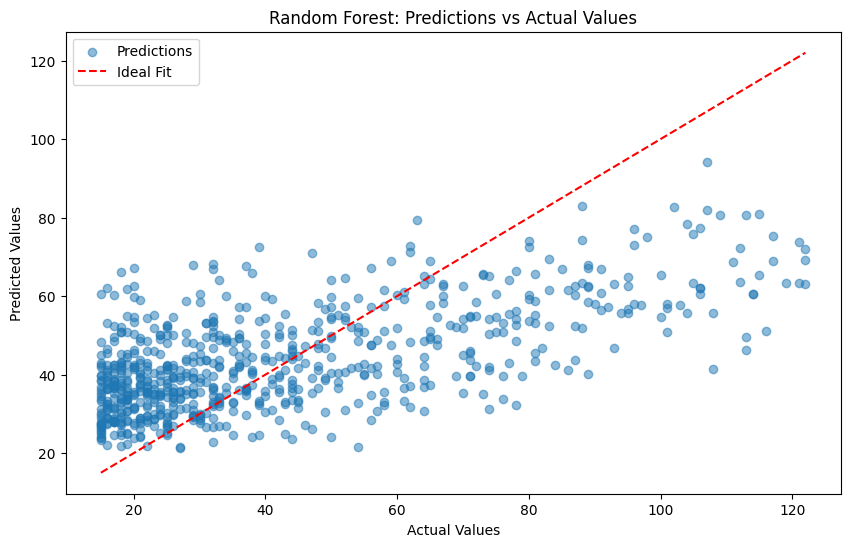

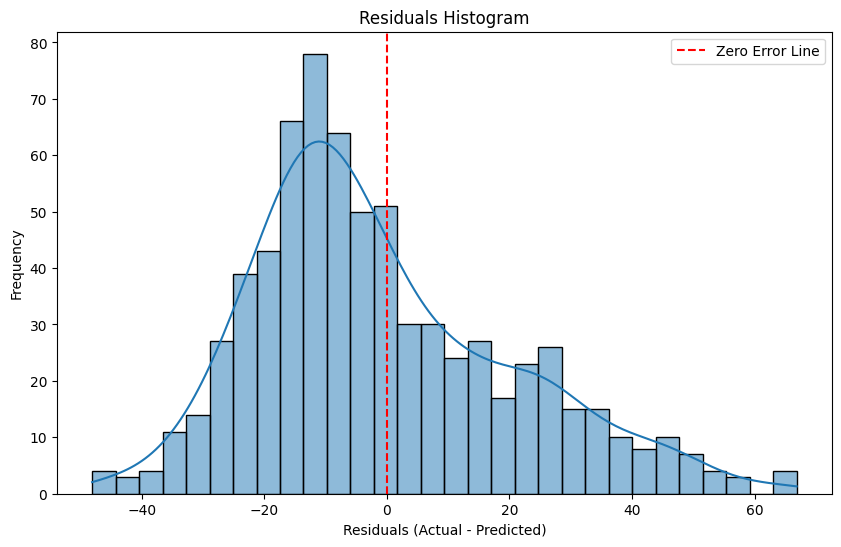

In [19]:
import matplotlib.pyplot as plt

# Plot predictions vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5, label="Predictions")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label="Ideal Fit")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Random Forest: Predictions vs Actual Values")
plt.legend()
plt.show()

# Compute residuals
residuals = y_test - y_pred

# Plot histogram
plt.figure(figsize=(10, 6))
sns.histplot(residuals, bins=30, kde=True)  # KDE adds a smooth curve

# Formatting
plt.axvline(0, color='r', linestyle='--', label="Zero Error Line")
plt.xlabel("Residuals (Actual - Predicted)")
plt.ylabel("Frequency")
plt.title("Residuals Histogram")
plt.legend()
plt.show()

# Feature Selection

In [20]:
import pandas as pd

# Get feature importances
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rand_forest.feature_importances_
}).sort_values(by='Importance', ascending=False)

print(feature_importance)  # Display important features

                           Feature  Importance
5                        CRS_DEP_M    0.202306
14                         sch_arr    0.103017
13                         sch_dep    0.086215
6                        CRS_ARR_M    0.070265
3                 CRS_ELAPSED_TIME    0.057296
..                             ...         ...
109      Condition_Drizzle and Fog    0.000000
115   Condition_Heavy Rain / Windy    0.000000
118  Condition_Light Freezing Rain    0.000000
129                 Condition_Snow    0.000000
131   Condition_Wintry Mix / Windy    0.000000

[132 rows x 2 columns]


In [21]:
# # Set threshold
# threshold = 0.05

# # Select important features
# selected_features = feature_importance[feature_importance["Importance"] > threshold]["Feature"].tolist()

# print("Selected Features:", selected_features)

# # Filter dataset
# X_train_selected = X_train[selected_features]
# X_test_selected = X_test[selected_features]

Tried removing different portions of the features but all improvements were negligible in MSE or MAE. Overall feature selection did not benefit Random Forest Regression.

## Hyperparameter Tuning

In [22]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
import numpy as np

params = {
    'max_depth': np.arange(5, 100, 2), 
    'n_estimators': np.arange(50, 1000, 50),  
    'min_samples_split': [2, 3, 5, 10, 20, 50, 100], 
    'min_samples_leaf': [1, 2, 3, 4, 6, 8, 10],  
    'max_features': ['sqrt', 'log2', None], 
    'bootstrap': [True, False],
    'min_weight_fraction_leaf': np.linspace(0.0, 0.5, 6)
}

# RandomizedSearchCV with a large number of random combinations
random_search = RandomizedSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_distributions=params,
    n_iter=250,  
    cv=5,
    n_jobs=-1,
    scoring='neg_mean_squared_error',
    verbose=1,
    random_state=42,
    return_train_score=True
)

# Fit the model
random_search.fit(X_train, y_train)

# Output best parameters
print("Best parameters:", random_search.best_params_)


Fitting 5 folds for each of 250 candidates, totalling 1250 fits
Best parameters: {'n_estimators': np.int64(650), 'min_weight_fraction_leaf': np.float64(0.0), 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': None, 'max_depth': np.int64(77), 'bootstrap': True}


In [23]:
# Train model with best parameters
clf_best = RandomForestRegressor(
    random_state=42,
    max_depth=random_search.best_params_['max_depth'],
    n_estimators=random_search.best_params_['n_estimators'],
    min_samples_split=random_search.best_params_['min_samples_split'],
    min_samples_leaf=random_search.best_params_['min_samples_leaf'],
    max_features=random_search.best_params_['max_features'],
    bootstrap=random_search.best_params_['bootstrap'],
    min_weight_fraction_leaf=random_search.best_params_['min_weight_fraction_leaf']
)

# Fit the model
clf_best.fit(X_train, y_train)

# Predict using the best model
y_pred = clf_best.predict(X_test)

# Calculate MSE
mse = mean_squared_error(y_test, y_pred)
print("Random Forest MSE:", mse)

# Calculate MAE
mae = mean_absolute_error(y_test, y_pred)
print("Random Forest MAE:", mae)


Random Forest MSE: 442.8243772040802
Random Forest MAE: 17.029612962582338


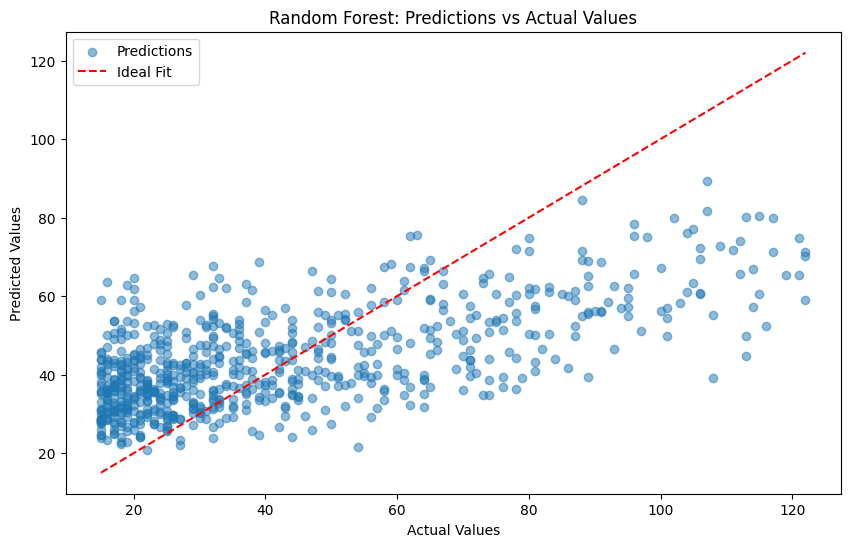

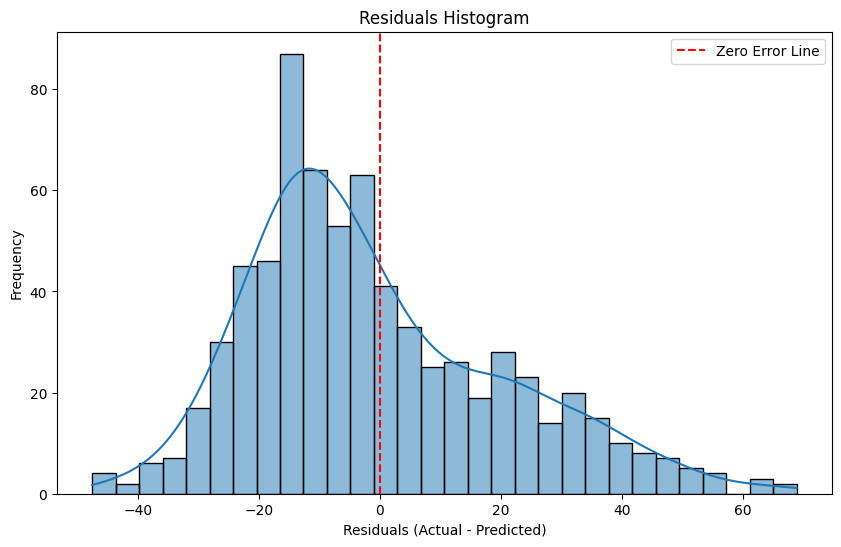

In [24]:
# Plot predictions vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5, label="Predictions")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label="Ideal Fit")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Random Forest: Predictions vs Actual Values")
plt.legend()
plt.show()

# Compute residuals
residuals = y_test - y_pred

# Plot histogram
plt.figure(figsize=(10, 6))
sns.histplot(residuals, bins=30, kde=True)  # KDE adds a smooth curve

# Formatting
plt.axvline(0, color='r', linestyle='--', label="Zero Error Line")
plt.xlabel("Residuals (Actual - Predicted)")
plt.ylabel("Frequency")
plt.title("Residuals Histogram")
plt.legend()
plt.show()

# Log Transform with Hyperparameter Tuning (no improvement)

In [25]:
import numpy as np
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# Apply log transformation to the target variable (DEP_DELAY)
y_train_log = np.log1p(y_train)  # log1p is log(1 + x) to avoid log(0) issues
y_test_log = np.log1p(y_test)

# Define a much larger hyperparameter grid for RandomizedSearchCV
params = {
    'max_depth': np.arange(5, 100, 2),  # Increased max_depth range
    'n_estimators': np.arange(50, 1000, 50),  # Increased range for n_estimators
    'min_samples_split': [2, 3, 5, 10, 20, 50, 100],  # Added more values for min_samples_split
    'min_samples_leaf': [1, 2, 3, 4, 6, 8, 10],  # Expanded options for min_samples_leaf
    'max_features': ['sqrt', 'log2', None],  # Added 'auto' and 'None' options
    'bootstrap': [True, False],
    'min_weight_fraction_leaf': np.linspace(0.0, 0.5, 6)
}

# RandomizedSearchCV with a large number of random combinations to try (e.g., 250 iterations)
random_search = RandomizedSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_distributions=params,
    n_iter=250,  # Increased number of random combinations to try
    cv=5,
    n_jobs=-1,
    scoring='neg_mean_squared_error',
    verbose=1,
    random_state=42,
    return_train_score=True
)

# Fit the model with log-transformed target variable
random_search.fit(X_train, y_train_log)

# Output best parameters
print("Best parameters:", random_search.best_params_)

# Predict on the test set using the best model
y_pred_log = random_search.predict(X_test)

# Since we transformed the target variable, we need to apply the inverse of the log transform
y_pred = np.expm1(y_pred_log)  # Inverse of log1p (expm1 is exp(x) - 1)
y_test_original = np.expm1(y_test_log)

# Calculate MSE and MAE on the original scale
mse = mean_squared_error(y_test_original, y_pred)
mae = np.mean(np.abs(y_test_original - y_pred))

print("MSE on original scale:", mse)
print("MAE on original scale:", mae)


Fitting 5 folds for each of 250 candidates, totalling 1250 fits
Best parameters: {'n_estimators': np.int64(650), 'min_weight_fraction_leaf': np.float64(0.0), 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': None, 'max_depth': np.int64(77), 'bootstrap': True}
MSE on original scale: 480.39356017825827
MAE on original scale: 16.652031455683122


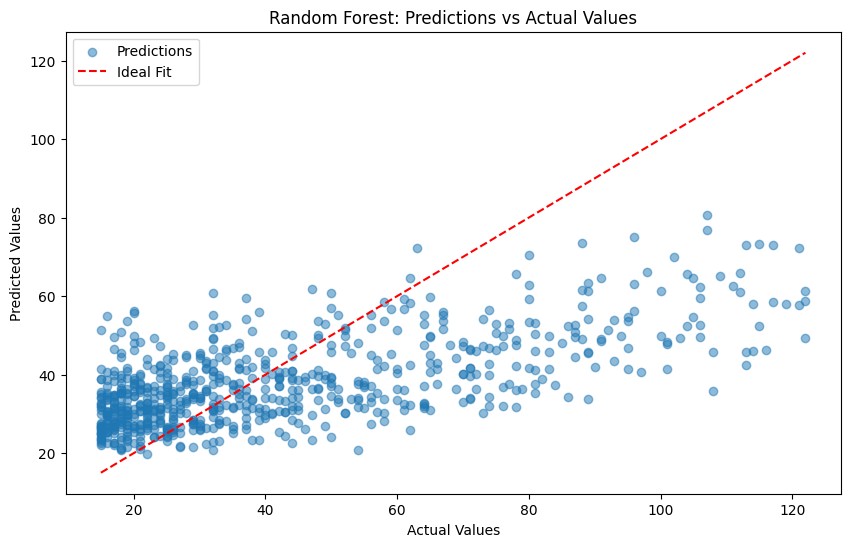

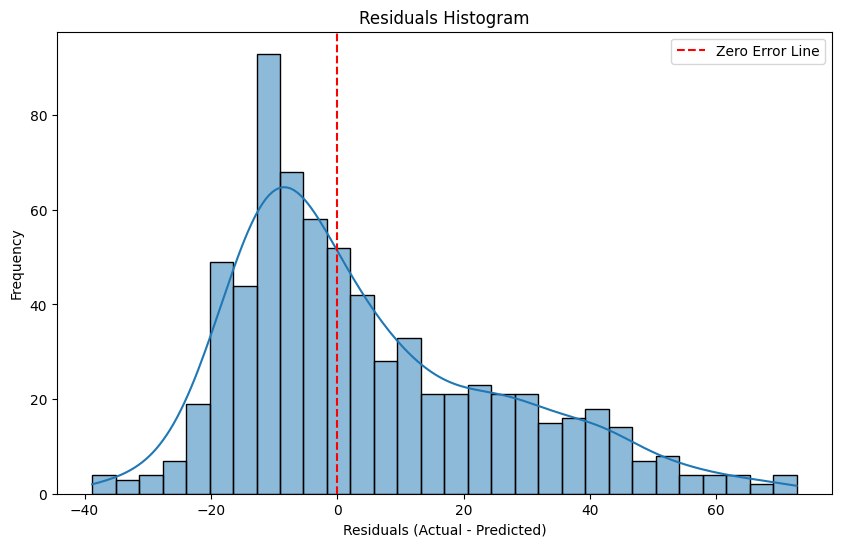

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Plot predictions vs actual values (on original scale)
plt.figure(figsize=(10, 6))
plt.scatter(y_test_original, y_pred, alpha=0.5, label="Predictions")
plt.plot([y_test_original.min(), y_test_original.max()], 
         [y_test_original.min(), y_test_original.max()], 
         'r--', label="Ideal Fit")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Random Forest: Predictions vs Actual Values")
plt.legend()
plt.show()

# Compute residuals (on original scale)
residuals = y_test_original - y_pred

# Plot histogram of residuals
plt.figure(figsize=(10, 6))
sns.histplot(residuals, bins=30, kde=True)  # KDE adds a smooth curve

# Formatting
plt.axvline(0, color='r', linestyle='--', label="Zero Error Line")
plt.xlabel("Residuals (Actual - Predicted)")
plt.ylabel("Frequency")
plt.title("Residuals Histogram")
plt.legend()
plt.show()
